In [1]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization,LeakyReLU,Conv2DTranspose,Input,Reshape,Conv2D,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
filename = "/root/.kaggle/"  # NOTE: This is taken from a Medium post! kaggle API is weird!
os.makedirs(os.path.dirname(filename), exist_ok=True)

In [4]:
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle_api/kaggle.json' "/root/.kaggle"

In [5]:
!kaggle datasets download -d splcher/animefacedataset

 97% 384M/395M [00:03<00:00, 147MB/s]
100% 395M/395M [00:03<00:00, 113MB/s]


In [6]:
!unzip animefacedataset.zip -d /content/animeset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/animeset/images/62764_2019.jpg  
  inflating: /content/animeset/images/62765_2019.jpg  
  inflating: /content/animeset/images/62766_2019.jpg  
  inflating: /content/animeset/images/62767_2019.jpg  
  inflating: /content/animeset/images/62768_2019.jpg  
  inflating: /content/animeset/images/62769_2019.jpg  
  inflating: /content/animeset/images/6276_2003.jpg  
  inflating: /content/animeset/images/62770_2019.jpg  
  inflating: /content/animeset/images/62771_2019.jpg  
  inflating: /content/animeset/images/62772_2019.jpg  
  inflating: /content/animeset/images/62773_2019.jpg  
  inflating: /content/animeset/images/62774_2019.jpg  
  inflating: /content/animeset/images/62775_2019.jpg  
  inflating: /content/animeset/images/62776_2019.jpg  
  inflating: /content/animeset/images/62777_2019.jpg  
  inflating: /content/animeset/images/62778_2019.jpg  
  inflating: /content/animeset/images/62779_2019.jpg  
  inflating: /c

In [7]:
from skimage.io import imread
def show_img(img_path):
  img = imread(img_path)
  plt.imshow(img)
  plt.show()

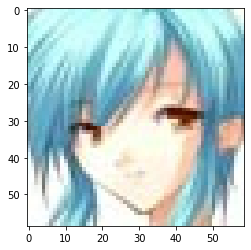

In [8]:
show_img("/content/animeset/images/9921_2004.jpg")

In [10]:
train_data_generator = ImageDataGenerator(rescale=1./255)

In [11]:
x_train = train_data_generator.flow_from_directory(
    '/content/animeset',
    target_size  = (64,64),
    batch_size = batch_size,
    shuffle = True
)

Found 63565 images belonging to 1 classes.


In [12]:
latent_space = 800

In [11]:
def generator_model(latent_space):
  i = Input(shape = (latent_space,1,1))
  x = Conv2DTranspose(512,(4,4),strides = (1,1), padding = "valid", use_bias = False)(i)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = Conv2DTranspose(256,(4,4),strides = (2,2), padding = "same", use_bias = False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = Conv2DTranspose(128,(4,4),strides = (2,2), padding = "same", use_bias = False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = Conv2DTranspose(64,(4,4),strides = (2,2), padding = "same", use_bias = False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)


  x = Conv2DTranspose(3,(5,5),strides = (2,2), padding = "same", use_bias = False,activation = "tanh")(x)

  model = Model(i,x,name = "generator")
  return model 

In [13]:
def gen_model_2(latent_dim):
    generator_input = Input(shape=(latent_dim,))

    x = Dense(128 * 32 * 32)(generator_input)
    x = LeakyReLU()(x)
    x = Reshape((32, 32, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(3, 7, activation='tanh', padding='same')(x)
    generator = Model(generator_input, x,name = "Generator_V2")

    return generator

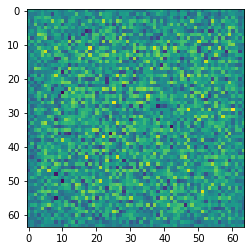

In [14]:
gen = gen_model_2(latent_space)
noise = tensorflow.random.normal([1,latent_space])
generated_image = gen(noise, training=False)
plt.imshow(generated_image[0,:,:,0])

In [15]:
gen.output_shape[1:]

(64, 64, 3)

In [16]:
def dis_model_2(gen_out = gen.output_shape[1:]):
  discriminator_input = Input(shape=gen_out)
  x = Conv2D(128, 3)(discriminator_input)
  x = LeakyReLU()(x)
  x = Conv2D(128, 4, strides=2)(x)
  x = LeakyReLU()(x)
  x = Conv2D(128, 4, strides=2)(x)
  x = LeakyReLU()(x)
  x = Conv2D(128, 4, strides=2)(x)
  x = LeakyReLU()(x)
  x = Flatten()(x)

  x = Dense(1, activation='sigmoid')(x)

  discriminator = Model(discriminator_input, x, name = "discriminator_V2")
  return discriminator

In [16]:
def discriminator_model(gen_out = gen.output_shape[1:]):
  i = Input(shape = (gen_out))

  x = Conv2D(64,(4,4),strides = (2,2),padding = "same",use_bias = False)(i)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)


  x = Conv2D(128,(4,4),strides = (2,2),padding = "same",use_bias = False)(i)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)

  x = Conv2D(256,(4,4),strides = (2,2),padding = "same",use_bias = False)(i)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)

  x = Conv2D(512,(4,4),strides = (2,2),padding = "same",use_bias = False)(i)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)

  x = Conv2D(1,(4,4),strides = (1,1),padding = "valid",use_bias = False)(i)

  x = Flatten()(x)
  x = Dense(1,activation = "sigmoid")(x)
  model = Model(i,x,name = "discriminator")
  return model

In [17]:
dis = dis_model_2()

In [18]:
dis.compile(optimizer = Adam(0.002,0.5), loss = "binary_crossentropy")
dis.trainable = False

z = Input(shape = (latent_space,))
img = gen(z)

fake_pred = dis(img)
c_model = Model(z,fake_pred)
c_model.compile(optimizer = Adam(0.0003,0.5),loss = "binary_crossentropy")

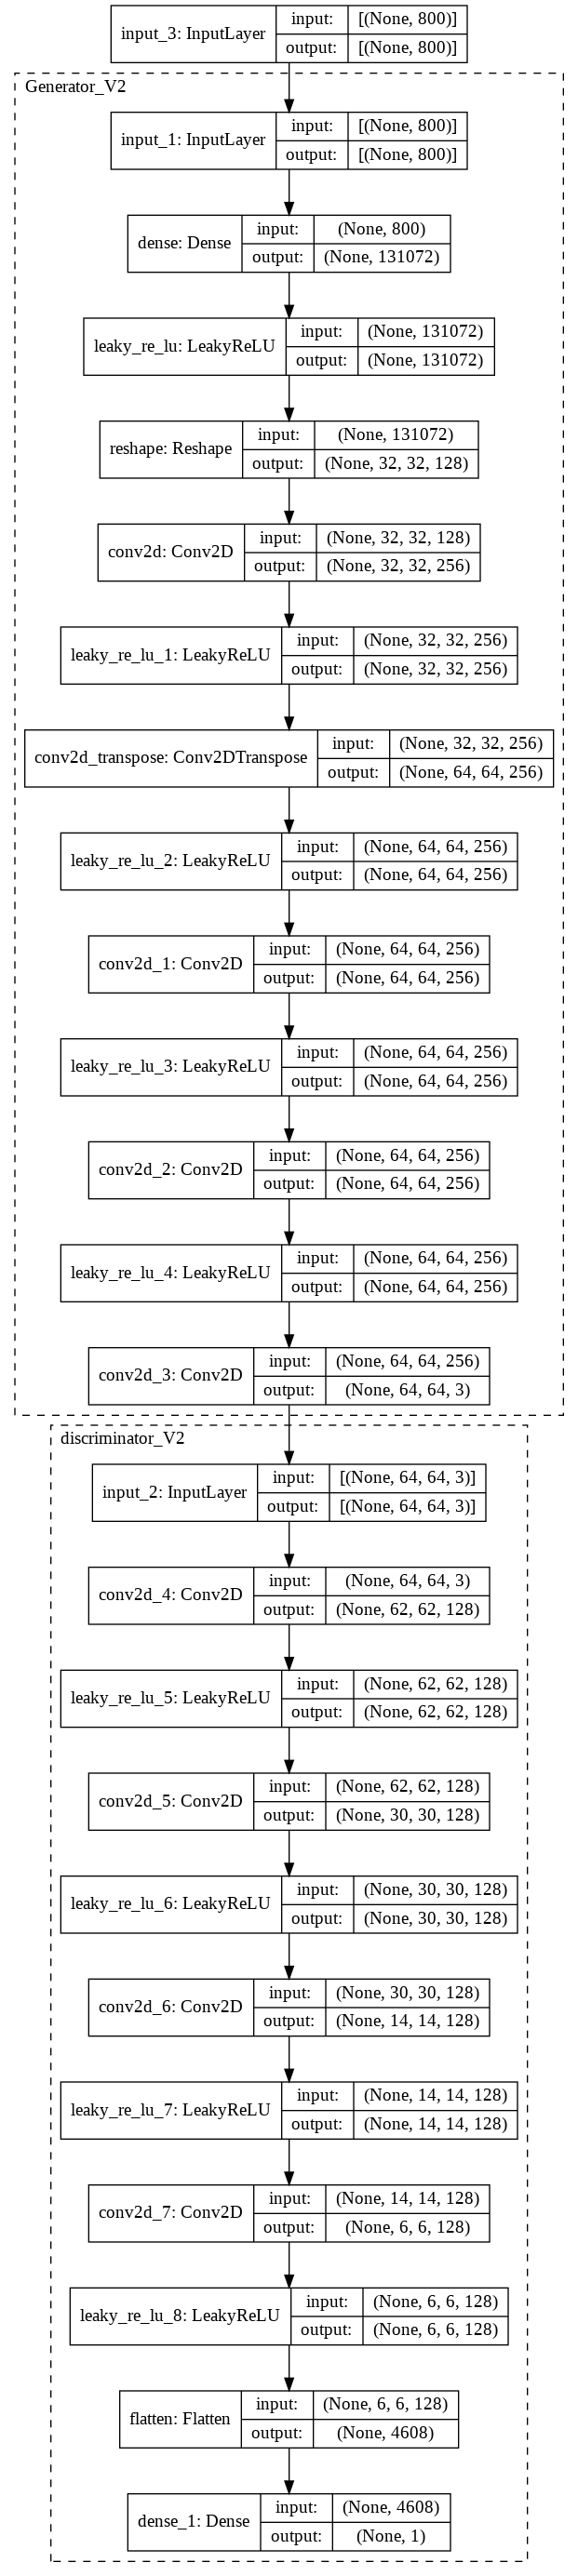

In [19]:
tensorflow.keras.utils.plot_model(c_model, show_shapes = True, expand_nested = True)

In [20]:
def sample_images(epoch):
  rows,cols = 5,5
  noise = np.random.randn(rows*cols,latent_space)
  imgs = gen.predict(noise)
  imgs = 0.5 * imgs + 0.5
  fig,axes = plt.subplots(rows,cols)
  index = 0
  for row in range(rows):
    for col in range(cols):
      axes[row,col].imshow(resize(imgs[index],(64,64)))
      axes[row,col].axis("off")
      index = index + 1
  fig.savefig(f"gan_images/{epoch}.png")
  plt.show()

In [30]:
batch_size = 32
epochs = 50000
sample_period = 500

zeros = np.zeros(batch_size)
ones = np.ones(batch_size)

g_losses = []
d_losses = []

if not os.path.exists("gan_images"):
  os.makedirs("gan_images")

In [31]:
from skimage.transform import rescale
from skimage.transform import resize
from glob import glob
imgs = glob("/content/animeset/images/*")

In [32]:
index = 0 
reset_lim = len(imgs)//batch_size

epoch : 1/50000  D-loss : 0.7212491035461426 G-loss : 0.69  💘 Anime tiddies YAY! 💘


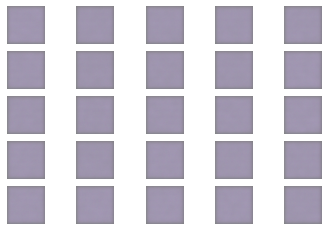

epoch : 501/50000  D-loss : 0.00016868015336513054 G-loss : 14.16  💘 Anime tiddies YAY! 💘


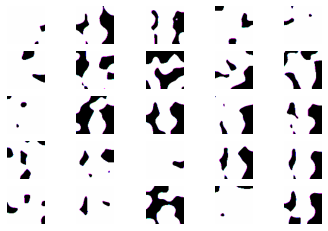

epoch : 1001/50000  D-loss : 2.8626468520087656e-05 G-loss : 18.82  💘 Anime tiddies YAY! 💘


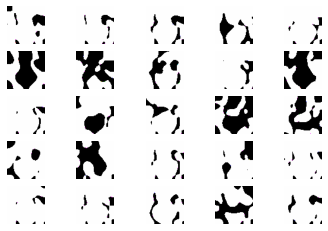

epoch : 1501/50000  D-loss : 1.549480521134683e-05 G-loss : 20.39  💘 Anime tiddies YAY! 💘


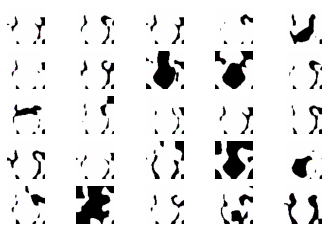

epoch : 2001/50000  D-loss : 1.5031490875117015e-05 G-loss : 19.44  💘 Anime tiddies YAY! 💘


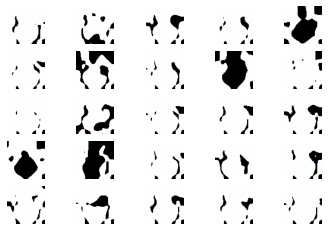

epoch : 2501/50000  D-loss : 1.2494891990399992e-05 G-loss : 22.86  💘 Anime tiddies YAY! 💘


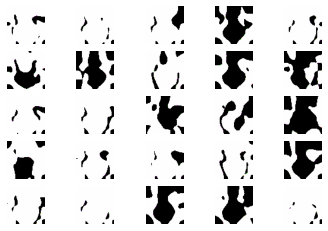

epoch : 3001/50000  D-loss : 2.2780609754136094e-06 G-loss : 24.19  💘 Anime tiddies YAY! 💘


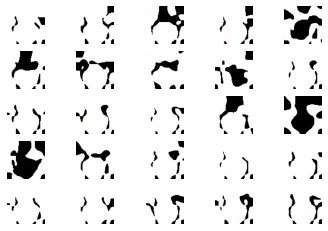

epoch : 3501/50000  D-loss : 1.1186955987341207e-05 G-loss : 24.04  💘 Anime tiddies YAY! 💘


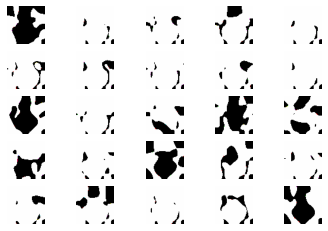

epoch : 4001/50000  D-loss : 4.810523535070388e-07 G-loss : 26.76  💘 Anime tiddies YAY! 💘


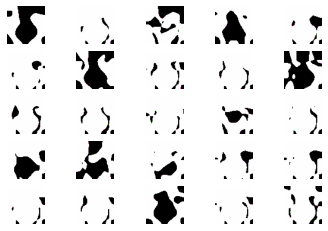

epoch : 4501/50000  D-loss : 1.7168160537650579e-07 G-loss : 22.98  💘 Anime tiddies YAY! 💘


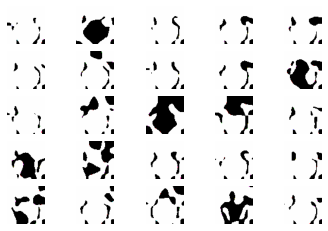

epoch : 5001/50000  D-loss : 4.981204604348477e-08 G-loss : 31.00  💘 Anime tiddies YAY! 💘


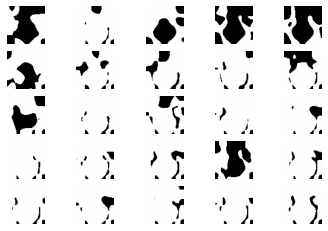

epoch : 5501/50000  D-loss : 6.38110095319e-08 G-loss : 29.37  💘 Anime tiddies YAY! 💘


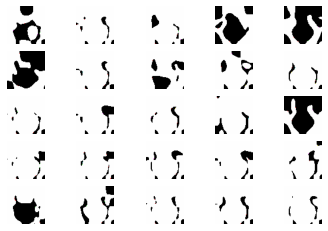

epoch : 6001/50000  D-loss : 7.808793123231794e-08 G-loss : 29.32  💘 Anime tiddies YAY! 💘


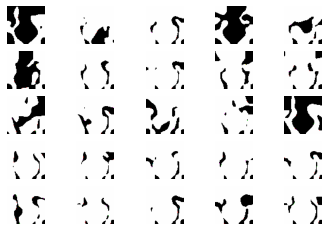

epoch : 6501/50000  D-loss : 3.44986368361333e-08 G-loss : 31.63  💘 Anime tiddies YAY! 💘


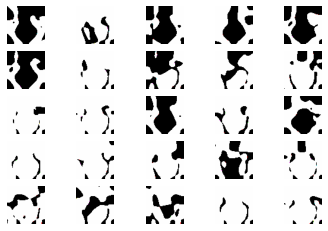

epoch : 7001/50000  D-loss : 2.9194377137997662e-08 G-loss : 34.63  💘 Anime tiddies YAY! 💘


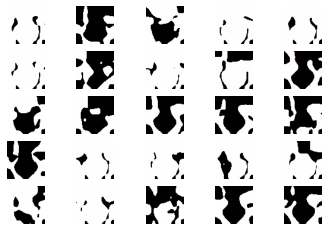

epoch : 7501/50000  D-loss : 6.037392807640551e-10 G-loss : 37.62  💘 Anime tiddies YAY! 💘


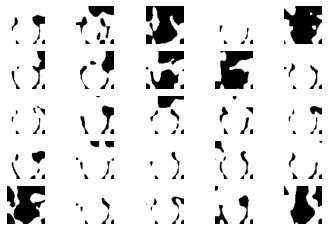

epoch : 8001/50000  D-loss : 2.5169579247414156e-09 G-loss : 36.01  💘 Anime tiddies YAY! 💘


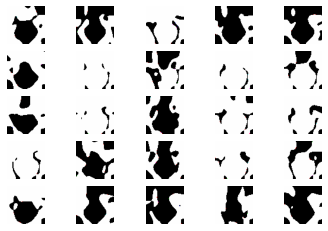

epoch : 8501/50000  D-loss : 0.000401463823436643 G-loss : 32.62  💘 Anime tiddies YAY! 💘


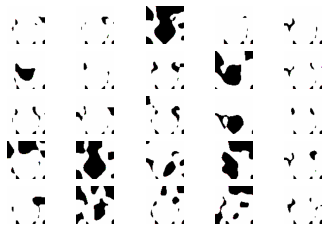

epoch : 9001/50000  D-loss : 0.00010591166756057646 G-loss : 37.55  💘 Anime tiddies YAY! 💘


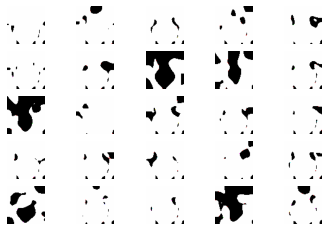

epoch : 9501/50000  D-loss : 4.312492342251062e-05 G-loss : 31.26  💘 Anime tiddies YAY! 💘


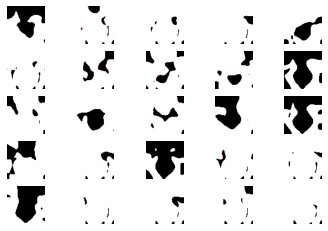

epoch : 10001/50000  D-loss : 0.0002584523754194379 G-loss : 33.85  💘 Anime tiddies YAY! 💘


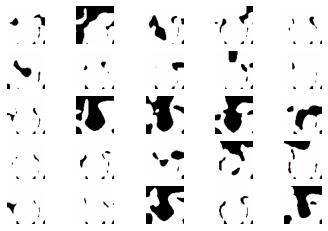

epoch : 10501/50000  D-loss : 1.963813815564208e-06 G-loss : 42.52  💘 Anime tiddies YAY! 💘


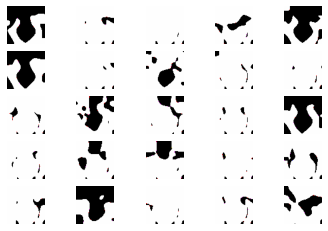

epoch : 11001/50000  D-loss : 7.319205543865337e-07 G-loss : 40.68  💘 Anime tiddies YAY! 💘


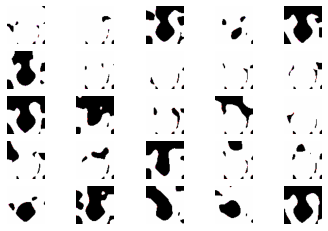

epoch : 11501/50000  D-loss : 7.984459955423517e-07 G-loss : 33.09  💘 Anime tiddies YAY! 💘


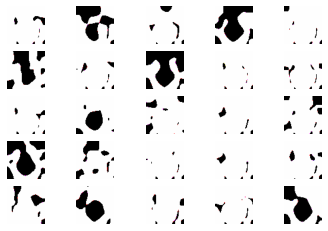

epoch : 12001/50000  D-loss : 2.268320285736536e-05 G-loss : 94.69  💘 Anime tiddies YAY! 💘


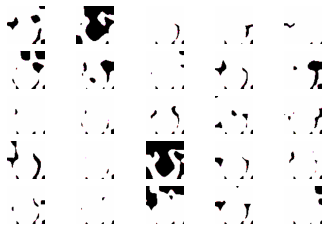

epoch : 12501/50000  D-loss : 1.1256669495196547e-05 G-loss : 81.62  💘 Anime tiddies YAY! 💘


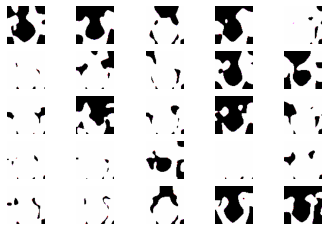

epoch : 13001/50000  D-loss : 0.0007885189370426815 G-loss : 72.16  💘 Anime tiddies YAY! 💘


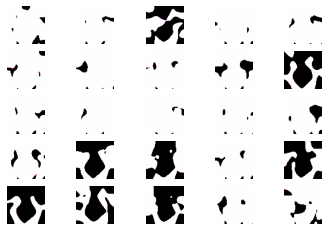

epoch : 13501/50000  D-loss : 9.737808799092917e-06 G-loss : 65.96  💘 Anime tiddies YAY! 💘


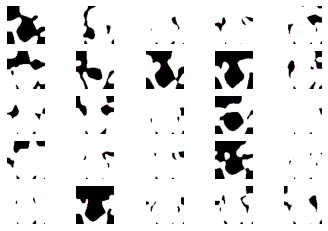

epoch : 14001/50000  D-loss : 6.348751318294155e-05 G-loss : 82.55  💘 Anime tiddies YAY! 💘


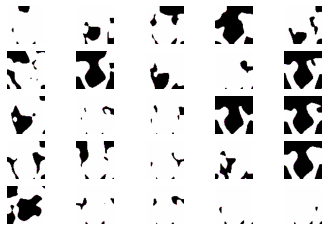

epoch : 14501/50000  D-loss : 2.3805134787835414e-06 G-loss : 112.79  💘 Anime tiddies YAY! 💘


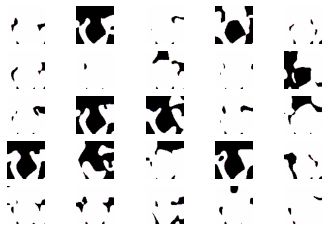

epoch : 15001/50000  D-loss : 7.16363413033605e-10 G-loss : 71.38  💘 Anime tiddies YAY! 💘


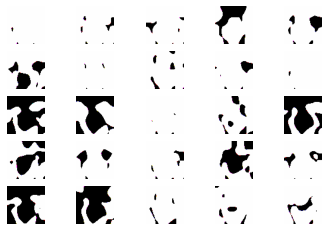

epoch : 15501/50000  D-loss : 2.9279389295311375e-06 G-loss : 63.48  💘 Anime tiddies YAY! 💘


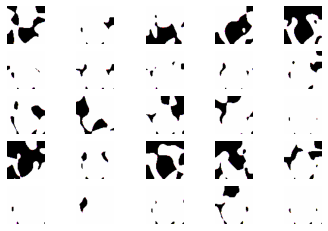

epoch : 16001/50000  D-loss : 9.170470216535165e-10 G-loss : 68.52  💘 Anime tiddies YAY! 💘


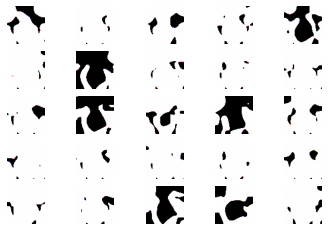

epoch : 16501/50000  D-loss : 3.2024199830490985e-07 G-loss : 85.85  💘 Anime tiddies YAY! 💘


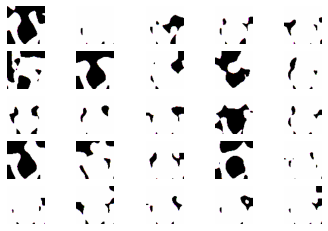

epoch : 17001/50000  D-loss : 8.351686550358206e-08 G-loss : 70.19  💘 Anime tiddies YAY! 💘


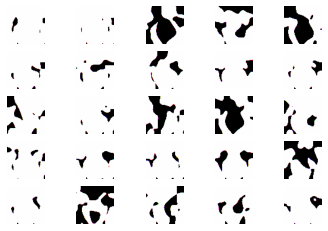

epoch : 17501/50000  D-loss : 6.06293297562995e-12 G-loss : 82.21  💘 Anime tiddies YAY! 💘


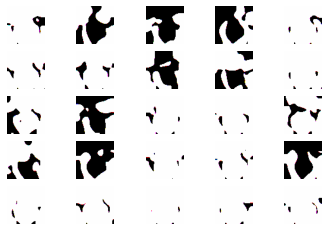

epoch : 18001/50000  D-loss : 2.6214791166816187e-09 G-loss : 84.07  💘 Anime tiddies YAY! 💘


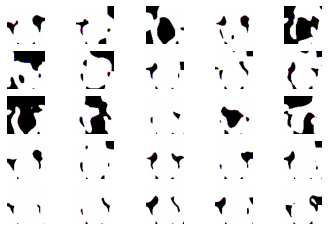

epoch : 18501/50000  D-loss : 6.713983313877251e-12 G-loss : 84.71  💘 Anime tiddies YAY! 💘


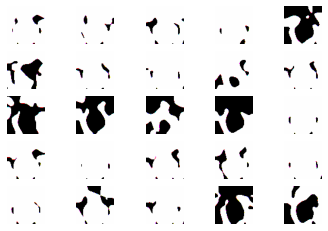

epoch : 19001/50000  D-loss : 2.030609846936926e-10 G-loss : 84.84  💘 Anime tiddies YAY! 💘


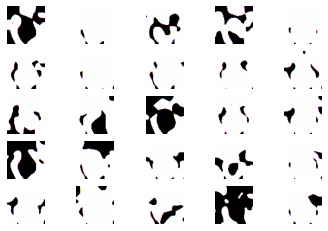

epoch : 19501/50000  D-loss : 1.1919696994650593e-09 G-loss : 93.75  💘 Anime tiddies YAY! 💘


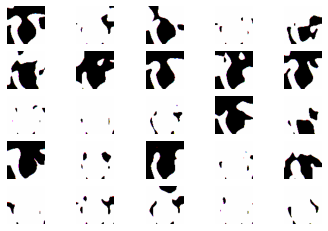

epoch : 20001/50000  D-loss : 6.8708986877559165e-06 G-loss : 373.40  💘 Anime tiddies YAY! 💘


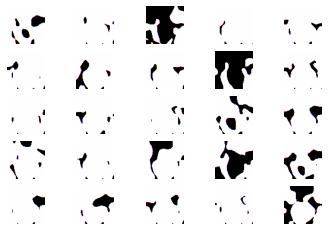

epoch : 20501/50000  D-loss : 6.72982801006583e-05 G-loss : 280.33  💘 Anime tiddies YAY! 💘


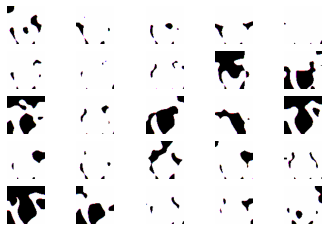

epoch : 21001/50000  D-loss : 1.2497841517244979e-07 G-loss : 279.55  💘 Anime tiddies YAY! 💘


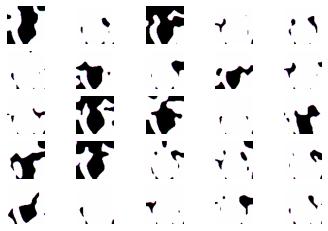

epoch : 21501/50000  D-loss : 5.570529820982106e-06 G-loss : 315.63  💘 Anime tiddies YAY! 💘


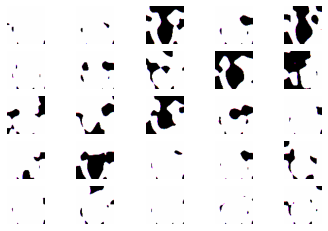

epoch : 22001/50000  D-loss : 0.0002603783710242169 G-loss : 226.45  💘 Anime tiddies YAY! 💘


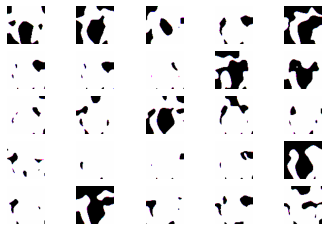

epoch : 22501/50000  D-loss : 5.190554963618865e-08 G-loss : 226.37  💘 Anime tiddies YAY! 💘


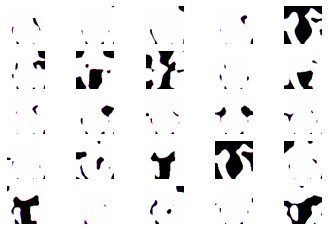

epoch : 23001/50000  D-loss : 4.104532527748894e-08 G-loss : 262.81  💘 Anime tiddies YAY! 💘


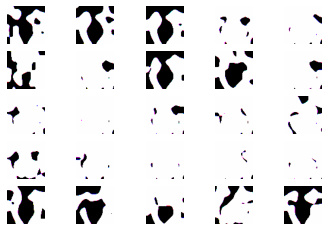

epoch : 23501/50000  D-loss : 5.025661116431213e-09 G-loss : 181.14  💘 Anime tiddies YAY! 💘


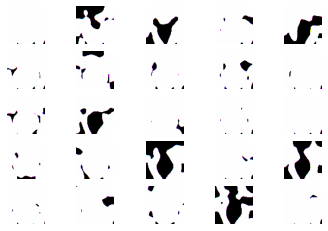

epoch : 24001/50000  D-loss : 1.3746456195562473e-09 G-loss : 262.66  💘 Anime tiddies YAY! 💘


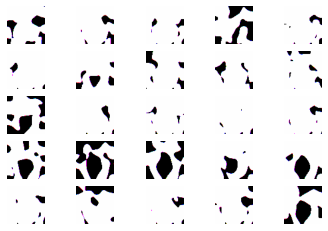

epoch : 24501/50000  D-loss : 7.608377819358269e-29 G-loss : 427.27  💘 Anime tiddies YAY! 💘


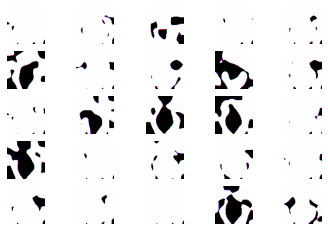

epoch : 25001/50000  D-loss : 2.2702768245023278e-14 G-loss : 311.04  💘 Anime tiddies YAY! 💘


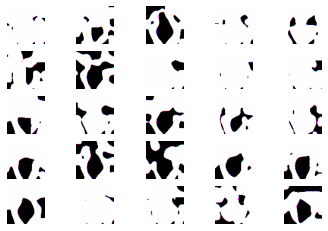

epoch : 25501/50000  D-loss : 5.354465174764366e-17 G-loss : 458.29  💘 Anime tiddies YAY! 💘


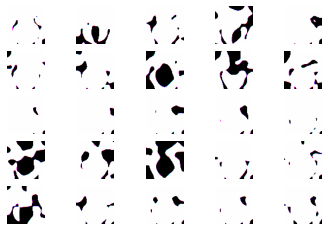

epoch : 26001/50000  D-loss : 1.6866733139697215e-33 G-loss : 683.75  💘 Anime tiddies YAY! 💘


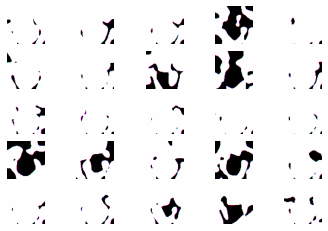

epoch : 26501/50000  D-loss : 2.4232358709071303e-26 G-loss : 632.83  💘 Anime tiddies YAY! 💘


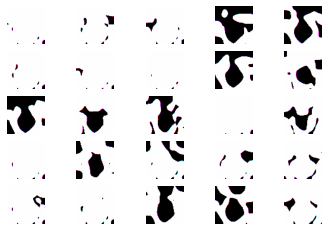

epoch : 27001/50000  D-loss : 2.5135271645087395e-08 G-loss : 759.78  💘 Anime tiddies YAY! 💘


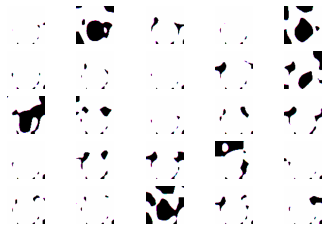

epoch : 27501/50000  D-loss : 1.1860988809513686e-13 G-loss : 630.16  💘 Anime tiddies YAY! 💘


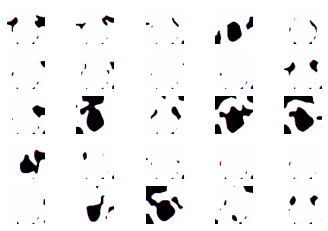

epoch : 28001/50000  D-loss : 4.170841731883368e-13 G-loss : 436.76  💘 Anime tiddies YAY! 💘


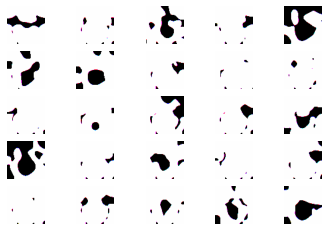

epoch : 28501/50000  D-loss : 7.237998380900917e-19 G-loss : 584.28  💘 Anime tiddies YAY! 💘


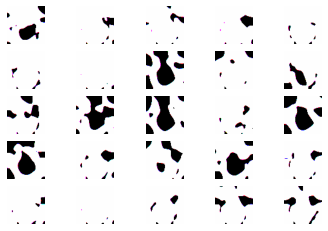

epoch : 29001/50000  D-loss : 1.597860732616141e-11 G-loss : 667.14  💘 Anime tiddies YAY! 💘


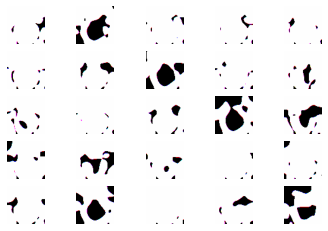

epoch : 29501/50000  D-loss : 3.0415416279322427e-12 G-loss : 565.45  💘 Anime tiddies YAY! 💘


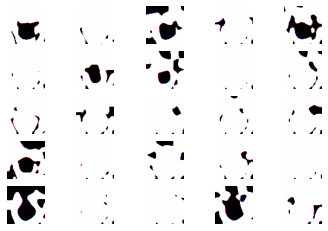

epoch : 30001/50000  D-loss : 6.783155715719622e-14 G-loss : 622.81  💘 Anime tiddies YAY! 💘


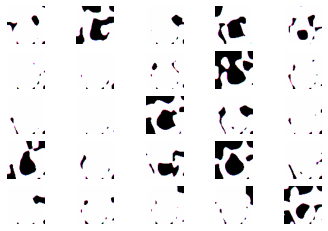

epoch : 30501/50000  D-loss : 2.892271141091467e-21 G-loss : 810.01  💘 Anime tiddies YAY! 💘


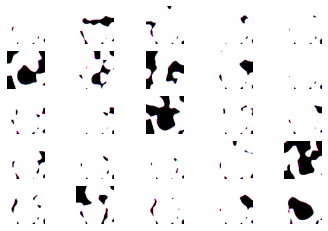

epoch : 31001/50000  D-loss : 9.806146564271692e-27 G-loss : 731.48  💘 Anime tiddies YAY! 💘


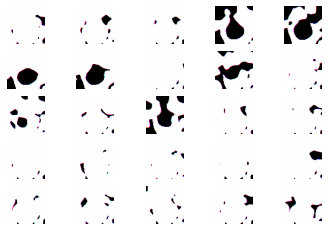

epoch : 31501/50000  D-loss : 6.895554594007396e-22 G-loss : 680.86  💘 Anime tiddies YAY! 💘


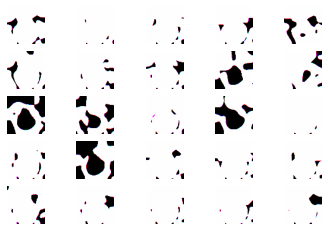

epoch : 32001/50000  D-loss : 1.3111149806902715e-13 G-loss : 678.30  💘 Anime tiddies YAY! 💘


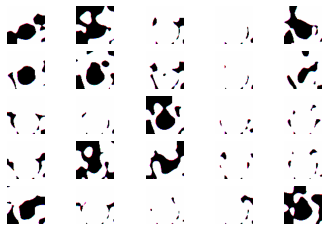

epoch : 32501/50000  D-loss : 5.645239012411457e-16 G-loss : 655.75  💘 Anime tiddies YAY! 💘


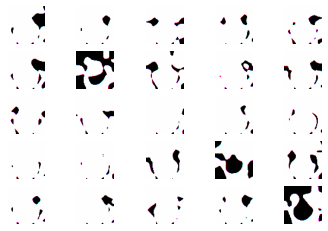

In [ ]:
for epoch in range(epochs):
  #------------preprocessing-------------
  if index >= reset_lim:
    index = 0
  random_imgs = imgs[index : index+batch_size]
  real_imgs = np.array([resize(imread(file_name), (64, 64)) for file_name in random_imgs])
  index = index + batch_size

  noise = np.random.randn(batch_size,latent_space) # random noise sampling from normal distribution 
  fake_imgs = gen.predict(noise)                   # fake_samples
  #----------train discriminator------------

  d_loss_r = dis.train_on_batch(real_imgs,ones)
  d_loss_f = dis.train_on_batch(fake_imgs,zeros)

  d_loss = 0.5 * (d_loss_r + d_loss_f)

  #--------------train generator--------------
  g_loss = c_model.train_on_batch(noise,ones)

  g_losses.append(g_loss)
  d_losses.append(d_loss)

  if epoch % 500 == 0 :
    print(f"epoch : {epoch+1}/{epochs}  D-loss : {d_loss} G-loss : {g_loss:.2f}  💘 Anime tiddies YAY! 💘")

  if epoch % sample_period == 0:
    sample_images(epoch)

In [ ]:
!ls gan_images

0.png	   16000.png  23000.png  30000.png  36500.png  43500.png  500.png
10000.png  16500.png  23500.png  3000.png   37000.png  44000.png  5500.png
1000.png   17000.png  24000.png  30500.png  37500.png  44500.png  6000.png
10500.png  17500.png  24500.png  31000.png  38000.png  45000.png  6500.png
11000.png  18000.png  25000.png  31500.png  38500.png  4500.png   7000.png
11500.png  18500.png  2500.png	 32000.png  39000.png  45500.png  7500.png
12000.png  19000.png  25500.png  32500.png  39500.png  46000.png  8000.png
12500.png  19500.png  26000.png  33000.png  40000.png  46500.png  8500.png
13000.png  20000.png  26500.png  33500.png  4000.png   47000.png  9000.png
13500.png  2000.png   27000.png  34000.png  40500.png  47500.png  9500.png
14000.png  20500.png  27500.png  34500.png  41000.png  48000.png
14500.png  21000.png  28000.png  35000.png  41500.png  48500.png
15000.png  21500.png  28500.png  3500.png   42000.png  49000.png
1500.png   22000.png  29000.png  35500.png  42500.png  4950

In [ ]:
from skimage.io import imread
show_img(imread("gan_images/48000.png"))